# Historical Stock Price Returns

# Import Data

**Historical Price Data**
- We can provide up to 20 years end of day stock price history for all of the exchanges we support. Intraday data (1, 5, 10, 15, 30 and 60 minute bars) is available back to Jan 1, 2008. All of our end of day historical stock prices have been cleaned for spikes and other anomalies and adjusted for splits.
https://www.eoddata.com/products/historicaldata.aspx

In [15]:
import pandas as pd
from pandas_gbq import to_gbq
import numpy as np
import matplotlib as mpb
import matplotlib.pyplot as plt

import itertools

In [2]:
# Google BigQuery Authentication

from google.cloud import bigquery
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import os
import pickle

# Set your OAuth client ID JSON downloaded from GCP Console
# CLIENT_SECRET_FILE = 'client_secret.json'  # downloaded from GCP
CLIENT_SECRET_FILE = os.path.expanduser("/Users/ryanrunchey/credentials/gcp_credentials/client_secret_295707256455-0fsr3bqoc89psl22fgp2cfipbd4m1s1v.apps.googleusercontent.com.json")
SCOPES = ['https://www.googleapis.com/auth/cloud-platform']

# Authenticate interactively (stores a token locally for reuse)
if os.path.exists('token.pickle'):
    with open('token.pickle', 'rb') as token:
        credentials = pickle.load(token)
else:
    flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRET_FILE, SCOPES)
    credentials = flow.run_local_server(port=0)
    with open('token.pickle', 'wb') as token:
        pickle.dump(credentials, token)

# Initialize the BigQuery client with those credentials
client = bigquery.Client(credentials=credentials, project="ryanrunchey")

In [3]:
# Import stock price returns data
query = "SELECT * FROM historical_stock_price_returns.stock_price_returns_2001_to_2023_number_of_days_425"

df_stock_price_returns = client.query(query).to_dataframe()
df_stock_price_returns

,exchange,symbol,date,close,number_of_days,date_end,close_end,price_difference,gain
0,OTCBB,AWON.OB,2020-10-29,0.0049,425,2021-12-28,0.0145,0.0096,1.959184
1,OTCBB,CSIOY.OB,2020-11-25,200.1200,425,2022-01-24,125.0000,-75.1200,-0.375375
2,OTCBB,HOCPF.OB,2021-06-18,131.2550,425,2022-08-17,108.0000,-23.2550,-0.177174
3,OTCBB,ICHGF.OB,2021-08-11,65.4500,425,2022-10-10,49.9350,-15.5150,-0.237051
4,OTCBB,BCKIF.OB,2021-12-23,3.9620,425,2023-02-21,3.8000,-0.1620,-0.040888
...,...,...,...,...,...,...,...,...,...
41259600,AMEX,BETZ,2024-11-29,20.5096,425,2026-01-28,NaN,NaN,NaN
41259601,NASDAQ,PNBK,2001-02-27,89.3750,425,2002-04-28,NaN,NaN,NaN
41259602,NASDAQ,ATLO,2001-10-29,13.2500,425,2002-12-28,NaN,NaN,NaN
41259603,NASDAQ,FITB,2003-01-20,58.1600,425,2004-03-20,NaN,NaN,NaN


In [4]:
df_stock_price_returns['date'].max()

Timestamp('2024-12-31 00:00:00')

### Check stock trading days in week

In [5]:
def get_dates_in_week(df, date_column, week_start_str, week_end_str):
    """
    Get all distinct dates from a DataFrame that fall within a specific week.
    
    Parameters:
        df (pd.DataFrame): Your DataFrame with a date column.
        date_column (str): Name of the date column.
        week_start_str (str): Start of the week, e.g. '2015-09-14'.
        week_end_str (str): End of the week, e.g. '2015-09-20'.
    
    Returns:
        pd.Series: Sorted list of distinct dates within the specified week.
    """
    # Ensure datetime format
    df = df.copy()
    df[date_column] = pd.to_datetime(df[date_column])

    # Filter by date range
    mask = (df[date_column] >= week_start_str) & (df[date_column] <= week_end_str)
    filtered_dates = df.loc[mask, date_column].drop_duplicates().sort_values()
    
    return filtered_dates.reset_index(drop=True)

In [6]:
get_dates_in_week(df_stock_price_returns, 'date', '2003-09-01', '2003-09-28')

0    2003-09-01
1    2003-09-02
2    2003-09-03
3    2003-09-04
4    2003-09-05
5    2003-09-08
6    2003-09-09
7    2003-09-10
8    2003-09-11
9    2003-09-12
10   2003-09-15
11   2003-09-16
12   2003-09-17
13   2003-09-18
14   2003-09-19
15   2003-09-22
16   2003-09-23
17   2003-09-24
18   2003-09-25
19   2003-09-26
Name: date, dtype: datetime64[us]

### Filter to the first trading date on or after 9/14 of each year with a price ("close_end") 425 days later

In [7]:
# The first date that 2.5 years LEAPs were available to trade each year

list_dates = ['2002-09-18', '2003-09-17', '2004-09-15', '2005-09-16', '2006-09-15', '2007-09-14', '2008-09-17', \
              '2009-09-16', '2010-09-15', '2011-09-16', '2012-09-14', '2013-09-18', '2014-09-17', '2015-09-16', \
              '2016-09-16', '2017-09-15', '2018-09-14', '2019-09-18', '2020-09-16', '2021-09-16', '2022-09-14']

pd_list_dates = pd.to_datetime(list_dates)  # ensure correct dtype

In [8]:
# Identify NaN close_end per date

# Total rows per date
mask = df_stock_price_returns['date'].isin(pd_list_dates)
total_counts = df_stock_price_returns[mask].groupby('date').size().rename('total_count')

# NaN close_end rows per date
mask = (df_stock_price_returns['date'].isin(pd_list_dates)) & (df_stock_price_returns['close_end'].isna())
nan_counts = df_stock_price_returns[mask] \
    .groupby('date') \
    .size() \
    .rename('nan_count')

# Combine into one DataFrame
result = pd.concat([total_counts, nan_counts], axis=1).fillna(0)

# Ensure counts are integers
result['nan_count'] = result['nan_count'].astype(int)
result['total_count'] = result['total_count'].astype(int)

# Compute percentage
result['nan_pct'] = result['nan_count'] / result['total_count']

# Reset index for a clean DataFrame
result = result.reset_index()

print("Total NaN Count: " + str(result['nan_count'].sum()))
print()
result

Total NaN Count: 10241



,date,total_count,nan_count,nan_pct
0,2002-09-18,2012,3,0.001491
1,2003-09-17,2079,31,0.014911
2,2004-09-15,2744,55,0.020044
3,2005-09-16,3437,153,0.044516
4,2006-09-15,3704,179,0.048326
5,2007-09-14,4409,544,0.123384
6,2008-09-17,4460,550,0.123318
7,2009-09-16,4626,326,0.070471
8,2010-09-15,4967,344,0.069257
9,2011-09-16,5382,570,0.105909


# Charts

In [11]:
# Truncate all returns greater than 1 to the value 1.1 for histogram binning purposes

def gains_limit(x):
    if x > 2:
        return 2.1
    else:
        return x

In [ ]:
# Select one example data series

mask = (df_stock_price_returns['date'] == '2018-09-14') & (df_stock_price_returns['close'] <= 1.25)
data = df_stock_price_returns[mask]['gain']

# account for stock tickers that don't have a close_end price. tbd the root cause: merger, bankruptcy, delisting, etc.
# conservative approach: treat as if they all were a complete loss meaning the stock price went to $0
data = data.fillna(-1)

data.describe()

In [ ]:
data_gains_limit = data.map(gains_limit)
data_gains_limit.describe()

## PDF and CDF

In [ ]:
# Plot the PDF and CDF

fig, ax1 = plt.subplots()

# Plot PDF on the first y-axis
data_gains_limit.plot.density(ax=ax1, label='PDF (KDE)', color='blue')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for CDF
ax2 = ax1.twinx()
data_gains_limit.hist(cumulative=True, density=True, bins=50, ax=ax2, label='CDF', histtype='step', color='red')
ax2.set_ylabel('Cumulative Probability', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('PDF and CDF')
fig.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

## Histogram

In [ ]:
plt.hist(data_gains_limit, bins=21, range=(-1, 1.1));

In [ ]:
data_gains_limit.describe()

In [ ]:
prob_neg_one = (data_gains_limit == -1).mean()
print(f"P(return = -1) = {prob_neg_one:.2%}")

In [ ]:
data = np.histogram(data_gains_limit, bins=21, range=(-1, 1.1))

d = {'bins': data[1], 'counts': np.append(data[0], np.nan)}
df_hist = pd.DataFrame(data=d)
df_hist['cum_sum'] = df_hist.sort_values('bins', ascending=False).counts.cumsum()
df_hist['pct_cum_sum'] = df_hist['cum_sum'] / df_hist['counts'].sum()
df_hist

## Histogram Charts

In [13]:
df_list = []

exchange = 'NASDAQ'

for date in list_dates:
    mask = (df_stock_price_returns['exchange'] == exchange) & (df_stock_price_returns['date'] == date) & (df_stock_price_returns['close'] <= 1.25)
    x = df_stock_price_returns[mask]['gain'].map(gains_limit)

    # account for stock tickers that don't have a close_end price. tbd the root cause: merger, bankruptcy, delisting, etc.
    # conservative approach: treat as if they all were a complete loss meaning the stock price went to $0
    x = x.fillna(-1)

    data = np.histogram(x, bins=31, range=(-1, 2.1))

    d = {'date': list(itertools.repeat(date, 32)), 'bins': data[1], 'counts': np.append(data[0], np.nan)}
    df_hist = pd.DataFrame(data=d)
    df_hist['cum_sum'] = df_hist.sort_values('bins', ascending=False).counts.cumsum()
    df_hist['pct_cum_sum'] = df_hist['cum_sum'] / df_hist['counts'].sum()
    
    df_list.append(df_hist)

df_histograms = pd.concat(df_list)
df_histograms.tail(50)

,date,bins,counts,cum_sum,pct_cum_sum
14,2021-09-16,0.4,0.0,24.0,0.342857
15,2021-09-16,0.5,1.0,24.0,0.342857
16,2021-09-16,0.6,2.0,23.0,0.328571
17,2021-09-16,0.7,2.0,21.0,0.300000
18,2021-09-16,0.8,0.0,19.0,0.271429
19,2021-09-16,0.9,2.0,19.0,0.271429
20,2021-09-16,1.0,0.0,17.0,0.242857
21,2021-09-16,1.1,2.0,17.0,0.242857
22,2021-09-16,1.2,0.0,15.0,0.214286
23,2021-09-16,1.3,1.0,15.0,0.214286


In [17]:
# Export to csv
df_histograms.to_csv("df_histograms_less_than_1_25_" + exchange + ".csv")

# Export to pickle
df_histograms.to_pickle("df_histograms_less_than_1_25_" + exchange + ".pkl")

# Export to BigQuery
to_gbq(
    dataframe=df_histograms,
    destination_table="historical_stock_price_returns.df_histograms_less_than_1_25_" + exchange,
    project_id="ryanrunchey",
    if_exists="replace"  # or "append"
)

100%|██████████| 1/1 [00:00<00:00, 3802.63it/s]


In [18]:
# sample size per year
df_histograms.groupby(['date']).agg({'counts': 'sum'})

,counts
date,
2002-09-18,47.0
2003-09-17,10.0
2004-09-15,14.0
2005-09-16,11.0
2006-09-15,14.0
2007-09-14,14.0
2008-09-17,43.0
2009-09-16,39.0
2010-09-15,29.0


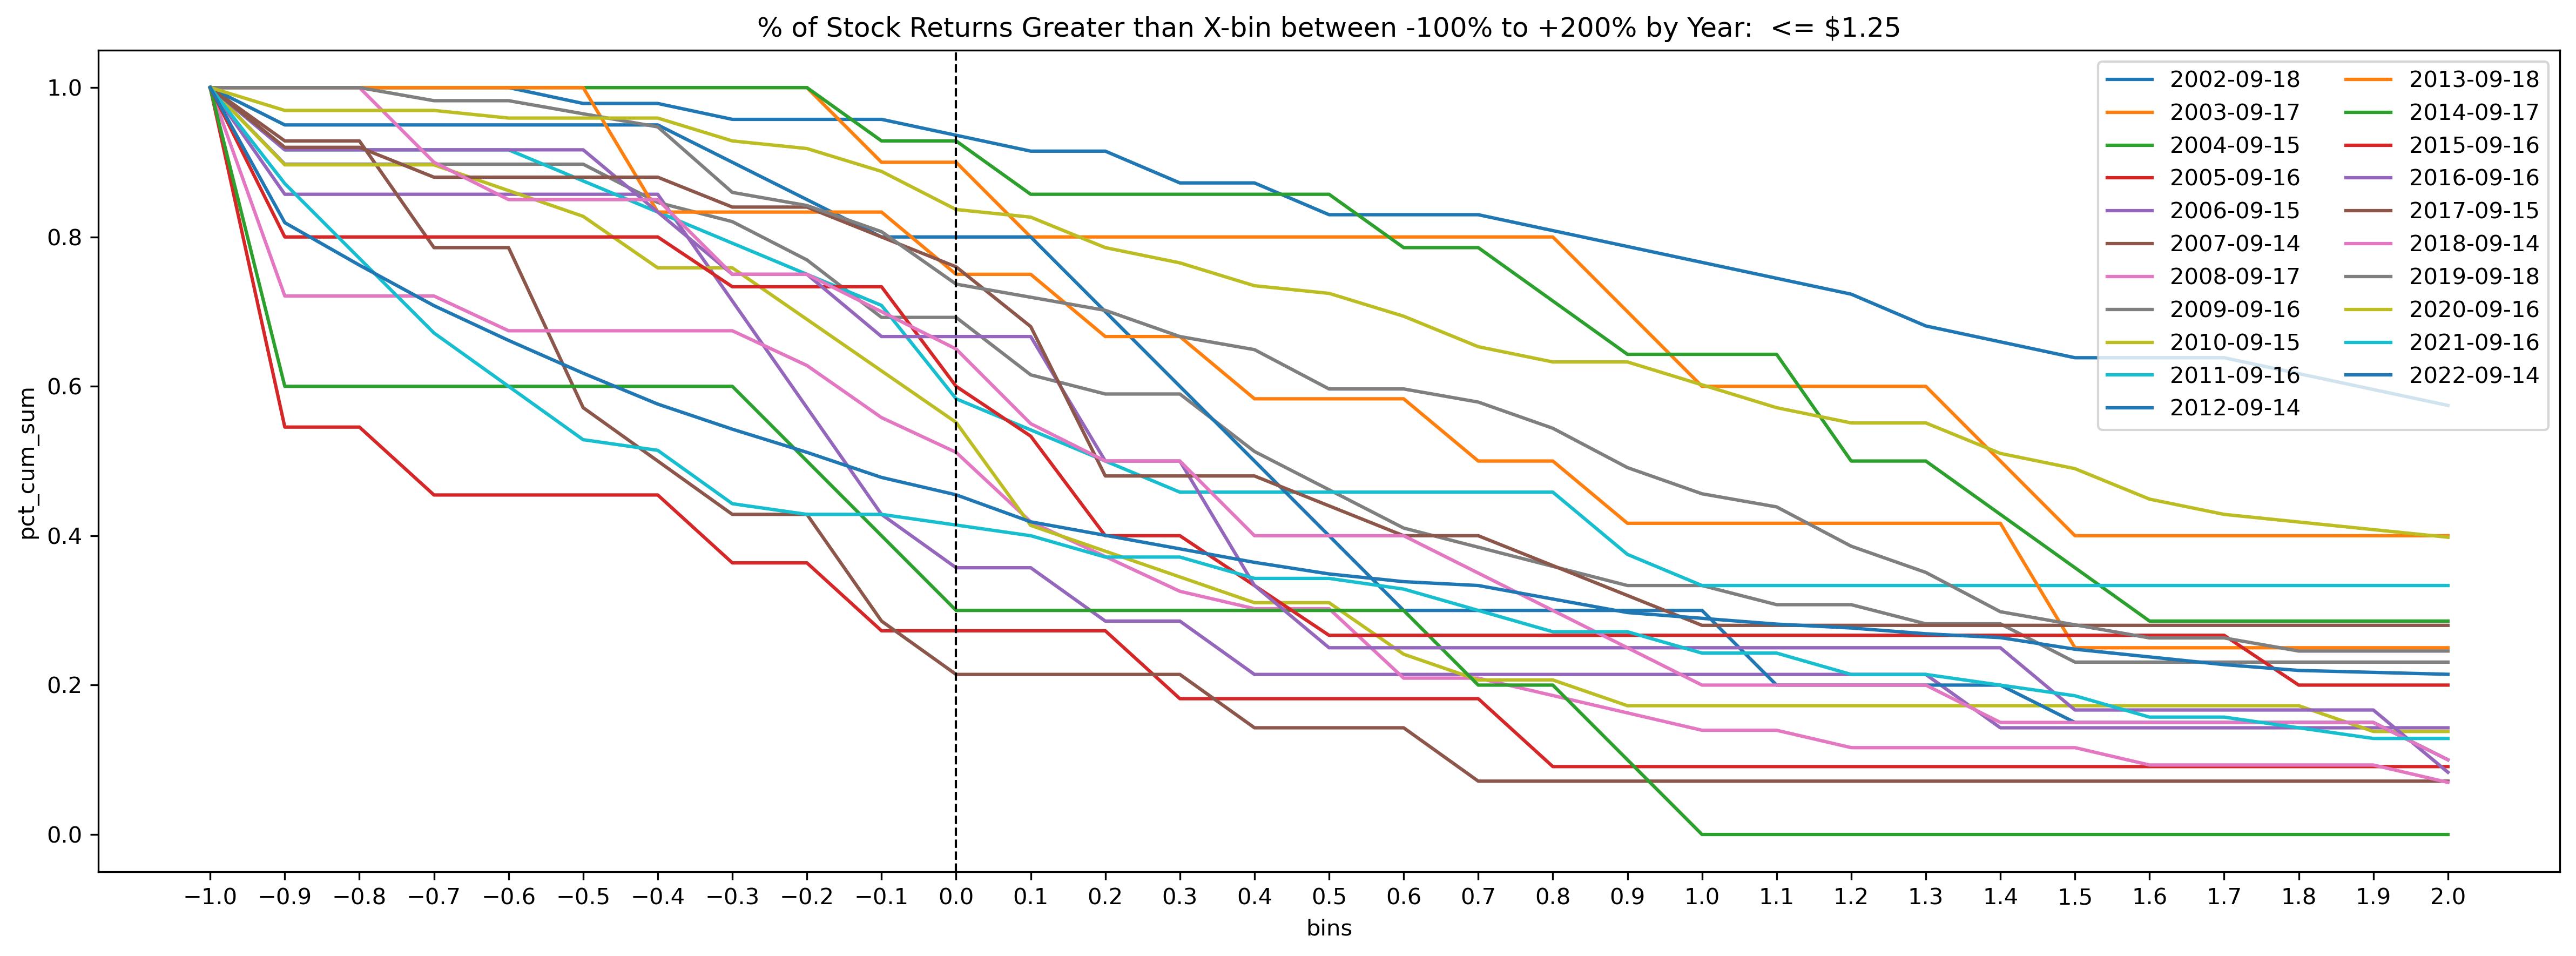

In [22]:
# Plot the histogram of each year's returns

plt.figure(figsize=(16, 6), dpi=300);
for d in list_dates:
    mask = (df_histograms['date'] == d)
    plt.plot('bins', 'pct_cum_sum', data=df_histograms[mask], label=d);

plt.title('% of Stock Returns Greater than X-bin between -100% to +200% by Year: ' + ' <= $1.25') # + exchange 
plt.ylabel('pct_cum_sum')
plt.xlabel('bins')
plt.xticks(ticks=[i/10 for i in range(-10, 21, 1)])
plt.legend(ncol=2, loc='upper right')

# 👉 Add vertical dashed line at x = 0.0
plt.axvline(x=0.0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()

# plt.savefig('chart_histograms_less_than_3_' + exchange + date_range + '.png', dpi='figure', bbox_inches=None, pad_inches=0.1,
            # facecolor='auto', edgecolor='auto');

## Aggregate of Histograms

In [23]:
df_histograms_agg = df_histograms.groupby(['bins']).agg({'counts': ['min', 'max', 'mean', 'median'], \
                                                         'pct_cum_sum': ['min', 'max', 'mean', 'median']})
df_histograms_agg

counts                         pct_cum_sum                              
        min   max       mean median         min       max      mean    median
bins                                                                         
-1.0    0.0  70.0   5.809524    2.0    1.000000  1.000000  1.000000  1.000000
-0.9    0.0  22.0   1.380952    0.0    0.545455  1.000000  0.886160  0.916667
-0.8    0.0  21.0   1.666667    0.0    0.545455  1.000000  0.878691  0.916667
-0.7    0.0  18.0   1.333333    0.0    0.454545  1.000000  0.852711  0.897436
-0.6    0.0  17.0   1.380952    0.0    0.454545  1.000000  0.840371  0.880000
-0.5    0.0  16.0   1.285714    0.0    0.454545  1.000000  0.819199  0.875000
-0.4    0.0  13.0   1.857143    1.0    0.454545  1.000000  0.792699  0.833333
-0.3    0.0  12.0   1.238095    1.0    0.363636  1.000000  0.747121  0.758621
-0.2    0.0  13.0   1.857143    1.0    0.363636  1.000000  0.719772  0.750000
-0.1    0.0   9.0   1.666667    1.0    0.272727  0.957447  0.661296  0.700000
 0.0    0.0  14.0   1.761905    1.0    0.214286  0.936170  0.615105  0.650000
 0.1    0.0   7.0   1.571429    1.0    0.214286  0.914894  0.573813  0.550000
 0.2    0.0   7.0   0.952381    0.0    0.214286  0.914894  0.523428  0.500000
 0.3    0.0   7.0   1.333333    1.0    0.181818  0.872340  0.502966  0.480000
 0.4    0.0   6.0   0.904762    0.0    0.142857  0.872340  0.460633  0.400000
 0.5    0.0   4.0   0.952381    0.0    0.142857  0.857143  0.438624  0.400000
 0.6    0.0   4.0   0.714286    0.0    0.142857  0.829787  0.415770  0.338501
 0.7    0.0   7.0   0.952381    1.0    0.071429  0.829787  0.394009  0.333333
 0.8    0.0   7.0   1.047619    1.0    0.071429  0.808511  0.373787  0.300000
 0.9    0.0   3.0   0.809524    1.0    0.071429  0.787234  0.340288  0.297158
 1.0    0.0   3.0   0.523810    0.0    0.000000  0.765957  0.317516  0.280000
 1.1    0.0   3.0   0.619048    0.0    0.000000  0.744681  0.307857  0.266667
 1.2    0.0   3.0   0.380952    0.0    0.000000  0.723404  0.293849  0.266667
 1.3    0.0   4.0   0.714286    0.0    0.000000  0.680851  0.288562  0.266667
 1.4    0.0   6.0   0.904762    1.0    0.000000  0.659574  0.268227  0.263566
 1.5    0.0   4.0   0.619048    0.0    0.000000  0.638298  0.239097  0.230769
 1.6    0.0   4.0   0.285714    0.0    0.000000  0.638298  0.229956  0.230769
 1.7    0.0   3.0   0.380952    0.0    0.000000  0.638298  0.228492  0.227390
 1.8    0.0   1.0   0.238095    0.0    0.000000  0.617021  0.221934  0.200000
 1.9    0.0   1.0   0.333333    0.0    0.000000  0.595745  0.217990  0.200000
 2.0    0.0  83.0  10.761905    4.0    0.000000  0.574468  0.206530  0.200000
 2.1    NaN   NaN        NaN    NaN         NaN       NaN       NaN       NaN

In [ ]:
df_histograms_agg.to_csv("df_histograms_agg_less_than_1_25_" + exchange + ".csv")

# Simulate Portfolio Returns

In [33]:
data_positions = [
    {"equity_exchange": "NASDAQ", "equity_symbol": "AEZS pre-split", "option_strike": 0.5, "avg_price_stock": 0.57, "avg_price_option": 0.42, "avg_price": 0.16, "total_order": 4288.10, "downside_to_break_even": -0.73, "pct_of_strike": 0.31, "pct_of_share_price": 0.27},
    {"equity_exchange": "AMEX", "equity_symbol": "IBIO pre-split", "option_strike": 0.5, "avg_price_stock": 0.47, "avg_price_option": 0.34, "avg_price": 0.13, "total_order": 11137.21, "downside_to_break_even": -0.72, "pct_of_strike": 0.27, "pct_of_share_price": 0.28},
    {"equity_exchange": "NASDAQ", "equity_symbol": "LPCN", "option_strike": 0.5, "avg_price_stock": 1.14, "avg_price_option": 0.97, "avg_price": 0.16, "total_order": 32.34, "downside_to_break_even": -0.86, "pct_of_strike": 0.32, "pct_of_share_price": 0.14},
    {"equity_exchange": "AMEX", "equity_symbol": "NAK", "option_strike": 0.5, "avg_price_stock": 0.44, "avg_price_option": 0.30, "avg_price": 0.14, "total_order": 12534.25, "downside_to_break_even": -0.69, "pct_of_strike": 0.28, "pct_of_share_price": 0.31},
    {"equity_exchange": "NASDAQ", "equity_symbol": "NMTR pre-split", "option_strike": 0.5, "avg_price_stock": 0.81, "avg_price_option": 0.66, "avg_price": 0.15, "total_order": 17952.00, "downside_to_break_even": -0.82, "pct_of_strike": 0.30, "pct_of_share_price": 0.18},
    {"equity_exchange": "NASDAQ", "equity_symbol": "NXTD pre-split", "option_strike": 0.5, "avg_price_stock": 0.39, "avg_price_option": 0.29, "avg_price": 0.10, "total_order": 10200.19, "downside_to_break_even": -0.74, "pct_of_strike": 0.20, "pct_of_share_price": 0.26},
    {"equity_exchange": "NASDAQ", "equity_symbol": "TXMD pre-split", "option_strike": 0.5, "avg_price_stock": 0.44, "avg_price_option": 0.31, "avg_price": 0.12, "total_order": 15467.52, "downside_to_break_even": -0.72, "pct_of_strike": 0.24, "pct_of_share_price": 0.28},
    {"equity_exchange": "AMEX", "equity_symbol": "UAMY", "option_strike": 0.5, "avg_price_stock": 0.87, "avg_price_option": 0.62, "avg_price": 0.25, "total_order": 7515.20, "downside_to_break_even": -0.72, "pct_of_strike": 0.49, "pct_of_share_price": 0.28},
    {"equity_exchange": "NASDAQ", "equity_symbol": "WTRH", "option_strike": 0.5, "avg_price_stock": 0.97, "avg_price_option": 0.84, "avg_price": 0.13, "total_order": 16227.15, "downside_to_break_even": -0.87, "pct_of_strike": 0.26, "pct_of_share_price": 0.13},
    {"equity_exchange": "NASDAQ", "equity_symbol": "ATHX pre-split", "option_strike": 1.0, "avg_price_stock": 0.67, "avg_price_option": 0.34, "avg_price": 0.33, "total_order": 10643.75, "downside_to_break_even": -0.51, "pct_of_strike": 0.33, "pct_of_share_price": 0.49},
    {"equity_exchange": "AMEX", "equity_symbol": "IBIO pre-split", "option_strike": 1.0, "avg_price_stock": 0.81, "avg_price_option": 0.54, "avg_price": 0.27, "total_order": 5149.44, "downside_to_break_even": -0.67, "pct_of_strike": 0.27, "pct_of_share_price": 0.33},
    {"equity_exchange": "NASDAQ", "equity_symbol": "IDEX", "option_strike": 1.0, "avg_price_stock": 2.04, "avg_price_option": 1.63, "avg_price": 0.41, "total_order": 206.70, "downside_to_break_even": -0.80, "pct_of_strike": 0.41, "pct_of_share_price": 0.20},
    {"equity_exchange": "NASDAQ", "equity_symbol": "LPCN", "option_strike": 1.0, "avg_price_stock": 1.03, "avg_price_option": 0.88, "avg_price": 0.14, "total_order": 56.16, "downside_to_break_even": -0.86, "pct_of_strike": 0.14, "pct_of_share_price": 0.14},
    {"equity_exchange": "NASDAQ", "equity_symbol": "NMTR pre-split", "option_strike": 1.0, "avg_price_stock": 0.73, "avg_price_option": 0.48, "avg_price": 0.25, "total_order": 5006.00, "downside_to_break_even": -0.66, "pct_of_strike": 0.25, "pct_of_share_price": 0.34},
    {"equity_exchange": "AMEX", "equity_symbol": "PLX", "option_strike": 1.0, "avg_price_stock": 1.16, "avg_price_option": 0.81, "avg_price": 0.35, "total_order": 10353.00, "downside_to_break_even": -0.70, "pct_of_strike": 0.35, "pct_of_share_price": 0.30},
    {"equity_exchange": "NASDAQ", "equity_symbol": "SESN", "option_strike": 1.0, "avg_price_stock": 0.78, "avg_price_option": 0.52, "avg_price": 0.26, "total_order": 2208.30, "downside_to_break_even": -0.67, "pct_of_strike": 0.26, "pct_of_share_price": 0.33},
    {"equity_exchange": "NASDAQ", "equity_symbol": "TYME pre-SYRS", "option_strike": 1.0, "avg_price_stock": 0.73, "avg_price_option": 0.45, "avg_price": 0.28, "total_order": 17985.50, "downside_to_break_even": -0.62, "pct_of_strike": 0.28, "pct_of_share_price": 0.38},
    {"equity_exchange": "AMEX", "equity_symbol": "UAMY", "option_strike": 1.0, "avg_price_stock": 0.88, "avg_price_option": 0.56, "avg_price": 0.32, "total_order": 6604.00, "downside_to_break_even": -0.64, "pct_of_strike": 0.32, "pct_of_share_price": 0.36},
    {"equity_exchange": "NASDAQ", "equity_symbol": "JAGX", "option_strike": 2.0, "avg_price_stock": 0.49, "avg_price_option": 0.23, "avg_price": 0.26, "total_order": 7674.00, "downside_to_break_even": -0.48, "pct_of_strike": 0.13, "pct_of_share_price": 0.52},
    {"equity_exchange": "NASDAQ", "equity_symbol": "CYCN", "option_strike": 2.5, "avg_price_stock": 2.34, "avg_price_option": 1.75, "avg_price": 0.59, "total_order": 4423.50, "downside_to_break_even": -0.75, "pct_of_strike": 0.24, "pct_of_share_price": 0.25}
]

data_positions = pd.DataFrame(data_positions)
data_positions

,equity_exchange,equity_symbol,option_strike,avg_price_stock,avg_price_option,avg_price,total_order,downside_to_break_even,pct_of_strike,pct_of_share_price
0,NASDAQ,AEZS pre-split,0.5,0.57,0.42,0.16,4288.10,-0.73,0.31,0.27
1,AMEX,IBIO pre-split,0.5,0.47,0.34,0.13,11137.21,-0.72,0.27,0.28
2,NASDAQ,LPCN,0.5,1.14,0.97,0.16,32.34,-0.86,0.32,0.14
3,AMEX,NAK,0.5,0.44,0.30,0.14,12534.25,-0.69,0.28,0.31
4,NASDAQ,NMTR pre-split,0.5,0.81,0.66,0.15,17952.00,-0.82,0.30,0.18
5,NASDAQ,NXTD pre-split,0.5,0.39,0.29,0.10,10200.19,-0.74,0.20,0.26
6,NASDAQ,TXMD pre-split,0.5,0.44,0.31,0.12,15467.52,-0.72,0.24,0.28
7,AMEX,UAMY,0.5,0.87,0.62,0.25,7515.20,-0.72,0.49,0.28
8,NASDAQ,WTRH,0.5,0.97,0.84,0.13,16227.15,-0.87,0.26,0.13
9,NASDAQ,ATHX pre-split,1.0,0.67,0.34,0.33,10643.75,-0.51,0.33,0.49


In [48]:
def calc_metrics(row):
    end_stock_price = row['avg_price_stock'] * (1 + row['sampled_stock_returns'])

    if end_stock_price >= row['option_strike']: 
        position_price = row['option_strike']
    else:
        position_price = end_stock_price
    
    position_roi = position_price / row['avg_price'] - 1
    position_value = row['total_order'] * (1 + position_roi)
    position_return = position_value - row['total_order']

    return pd.Series({
        'end_stock_price': end_stock_price,
        'position_price': position_price,
        'position_roi': position_roi,
        'position_value': position_value,
        'position_return': position_return
    })

In [49]:
def summarize_position_totals(df):
    """
    Calculate the total sum of 'total_order', 'position_value', and 'position_return' columns.
    
    Parameters:
        df (pd.DataFrame): DataFrame with required columns.

    Returns:
        dict: Dictionary with totals for each field and grand total.
    """
    total_order_sum = df['total_order'].sum()
    position_value_sum = df['position_value'].sum()
    position_return_sum = df['position_return'].sum()
    total_roi = position_value_sum / total_order_sum - 1
    
    return {
        'total_order_sum': total_order_sum,
        'position_value_sum': position_value_sum,
        'position_return_sum': position_return_sum,
        'total_roi': total_roi
    }

In [55]:
df_simulation_list = []

for date in pd_list_dates:

    # Select one year's worth of price returns
    # Account for stock tickers that don't have a close_end price. tbd the root cause: merger, bankruptcy, delisting, etc.
    # Conservative approach: treat as if they all were a complete loss meaning the stock price went to $0
    
    mask = ((df_stock_price_returns['date'] == date) & \
            (df_stock_price_returns['exchange'].isin(['AMEX', 'NASDAQ'])) & \
            (df_stock_price_returns['close'] <= 1.25))
    data = df_stock_price_returns[mask]['gain']
    data = data.fillna(-1)

    # Randomly sample returns with replacement

    for random_state in range(1,11):

        sampled_stock_returns = data.sample(n=len(data_positions), replace=True, random_state=random_state).reset_index(drop=True)

        # Calculate actual portfolio returns based upon historical price data samples
        
        df_returns = data_positions.copy(deep=True)
        df_returns['sampled_stock_returns_date'] = date
        df_returns['sampled_stock_returns_random_state'] = random_state
        df_returns['sampled_stock_returns'] = sampled_stock_returns
        df_returns[['end_stock_price', 'position_price', 'position_roi', 'position_value', 'position_return']] = df_returns.apply(calc_metrics, axis=1)        
        df_simulation_list.append(df_returns)

df_simulation = pd.concat(df_simulation_list)
df_simulation.head()

,equity_exchange,equity_symbol,option_strike,avg_price_stock,avg_price_option,avg_price,total_order,downside_to_break_even,pct_of_strike,pct_of_share_price,sampled_stock_returns_date,sampled_stock_returns_random_state,sampled_stock_returns,end_stock_price,position_price,position_roi,position_value,position_return
0,NASDAQ,AEZS pre-split,0.5,0.57,0.42,0.16,4288.10,-0.73,0.31,0.27,2002-09-18,1,0.989861,1.134221,0.5,2.125000,13400.312500,9112.212500
1,AMEX,IBIO pre-split,0.5,0.47,0.34,0.13,11137.21,-0.72,0.27,0.28,2002-09-18,1,0.071974,0.503828,0.5,2.846154,42835.423077,31698.213077
2,NASDAQ,LPCN,0.5,1.14,0.97,0.16,32.34,-0.86,0.32,0.14,2002-09-18,1,92.520000,106.612800,0.5,2.125000,101.062500,68.722500
3,AMEX,NAK,0.5,0.44,0.30,0.14,12534.25,-0.69,0.28,0.31,2002-09-18,1,11.494505,5.497582,0.5,2.571429,44765.178571,32230.928571
4,NASDAQ,NMTR pre-split,0.5,0.81,0.66,0.15,17952.00,-0.82,0.30,0.18,2002-09-18,1,0.787009,1.447477,0.5,2.333333,59840.000000,41888.000000


In [56]:
df_simulation.head()

,equity_exchange,equity_symbol,option_strike,avg_price_stock,avg_price_option,avg_price,total_order,downside_to_break_even,pct_of_strike,pct_of_share_price,sampled_stock_returns_date,sampled_stock_returns_random_state,sampled_stock_returns,end_stock_price,position_price,position_roi,position_value,position_return
0,NASDAQ,AEZS pre-split,0.5,0.57,0.42,0.16,4288.10,-0.73,0.31,0.27,2002-09-18,1,0.989861,1.134221,0.5,2.125000,13400.312500,9112.212500
1,AMEX,IBIO pre-split,0.5,0.47,0.34,0.13,11137.21,-0.72,0.27,0.28,2002-09-18,1,0.071974,0.503828,0.5,2.846154,42835.423077,31698.213077
2,NASDAQ,LPCN,0.5,1.14,0.97,0.16,32.34,-0.86,0.32,0.14,2002-09-18,1,92.520000,106.612800,0.5,2.125000,101.062500,68.722500
3,AMEX,NAK,0.5,0.44,0.30,0.14,12534.25,-0.69,0.28,0.31,2002-09-18,1,11.494505,5.497582,0.5,2.571429,44765.178571,32230.928571
4,NASDAQ,NMTR pre-split,0.5,0.81,0.66,0.15,17952.00,-0.82,0.30,0.18,2002-09-18,1,0.787009,1.447477,0.5,2.333333,59840.000000,41888.000000


In [57]:
# Summary Stats by Sampled Stock Returns Date and Random Seed

df_summary = (
    df_simulation
    .drop(columns=['sampled_stock_returns_date', 'sampled_stock_returns_random_state'])  # drop here
    .groupby([df_simulation['sampled_stock_returns_date'], df_simulation['sampled_stock_returns_random_state']], group_keys=False)
    .apply(lambda g: pd.Series(summarize_position_totals(g)))
    .reset_index()
)

df_summary.tail()

,sampled_stock_returns_date,sampled_stock_returns_random_state,total_order_sum,position_value_sum,position_return_sum,total_roi
205,2022-09-14,6,165664.31,358019.768264,192355.458264,1.161116
206,2022-09-14,7,165664.31,377747.031240,212082.721240,1.280196
207,2022-09-14,8,165664.31,276490.605053,110826.295053,0.668981
208,2022-09-14,9,165664.31,363437.553015,197773.243015,1.193819
209,2022-09-14,10,165664.31,528478.997544,362814.687544,2.190059


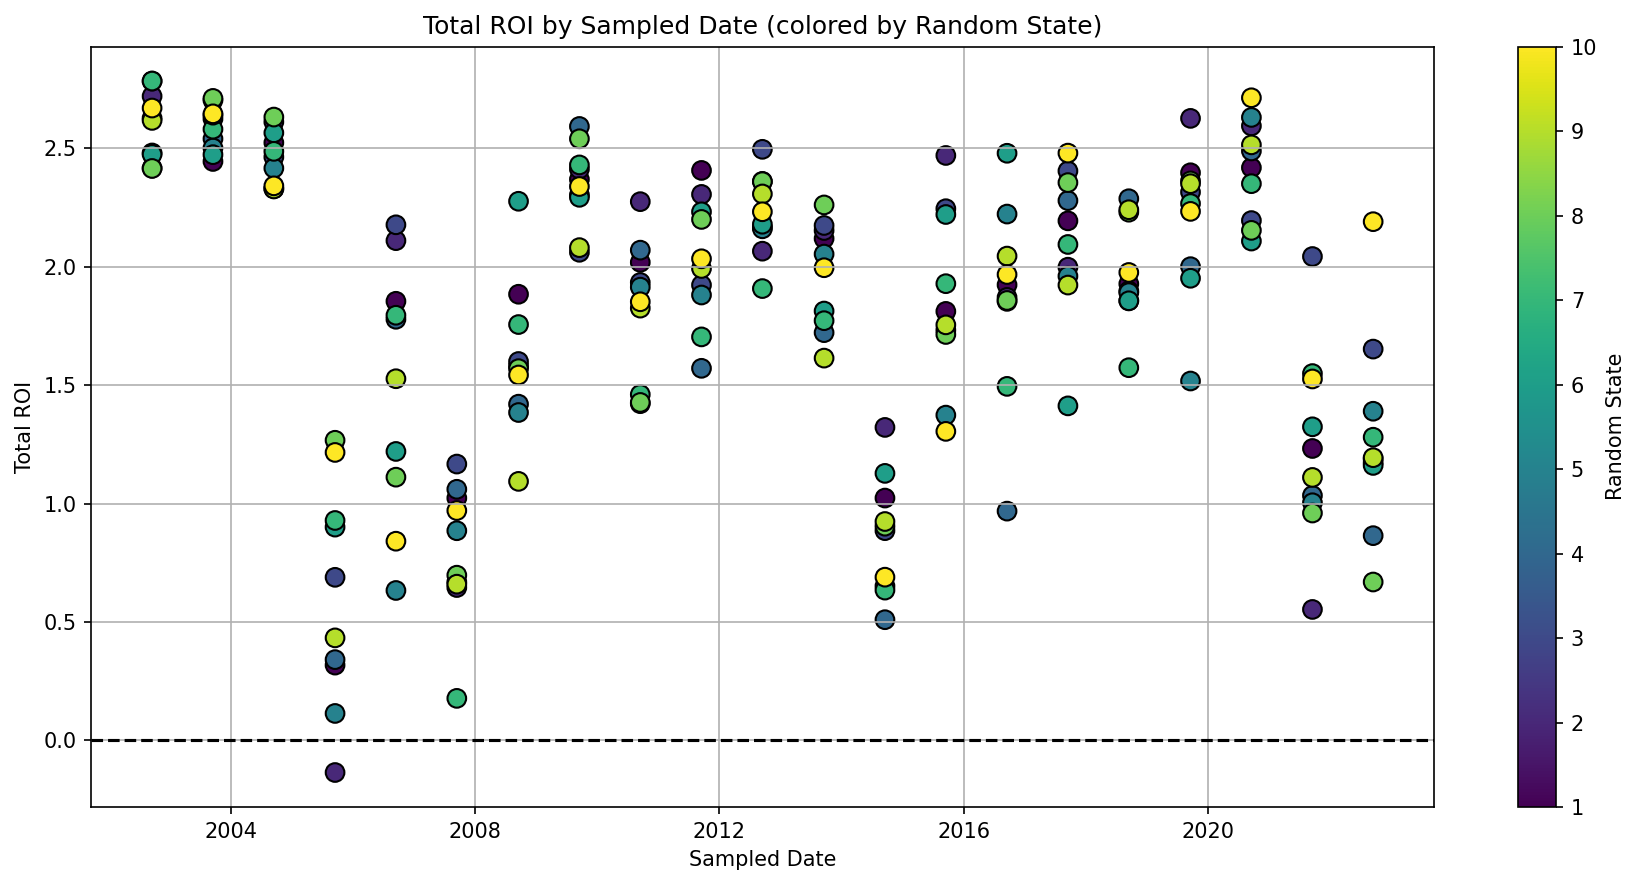

In [59]:
# If needed: ensure sampled_stock_returns_date is datetime
df_summary['sampled_stock_returns_date'] = pd.to_datetime(df_summary['sampled_stock_returns_date'])

# Create the scatter plot
plt.figure(figsize=(12, 6), dpi=150)

# Scatter: x = date, y = total_roi, color by random_state
scatter = plt.scatter(
    df_summary['sampled_stock_returns_date'],
    df_summary['total_roi'],
    c=df_summary['sampled_stock_returns_random_state'],
    cmap='viridis',
    s=80,
    edgecolors='black'
)

plt.axhline(y=0.0, color='black', linestyle='--', label='Break-even ROI')
plt.title('Total ROI by Sampled Date (colored by Random State)')
plt.xlabel('Sampled Date')
plt.ylabel('Total ROI')
plt.colorbar(scatter, label='Random State')
plt.grid(True)
plt.tight_layout()
plt.show()

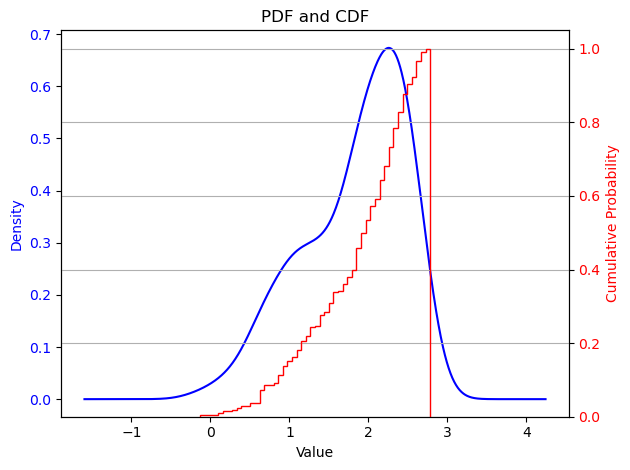

In [62]:
# Plot the PDF and CDF of the Portfolio ROI

df_total_roi = df_summary['total_roi'].copy(deep=True)

fig, ax1 = plt.subplots()

# Plot PDF on the first y-axis
df_total_roi.plot.density(ax=ax1, label='PDF (KDE)', color='blue')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for CDF
ax2 = ax1.twinx()
df_total_roi.hist(cumulative=True, density=True, bins=50, ax=ax2, label='CDF', histtype='step', color='red')
ax2.set_ylabel('Cumulative Probability', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('PDF and CDF')
fig.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()